# 아래는 5fold 11171637
절대 돌리지 않기

In [1]:
from google.colab import drive
drive.mount('/content/drive')


ValueError: mount failed

🔵 1. 경로 설정 + data.zip 풀기

In [ ]:
import os, shutil, zipfile, pathlib, random

BASE_DIR = "/content/drive/MyDrive/캡스톤_청소해조/제어팀_브리핑/코드모음/김승연_최종본"
ZIP_PATH = f"{BASE_DIR}/data.zip"

RAW_DIR = "/content/custom_data_raw"
shutil.rmtree(RAW_DIR, ignore_errors=True)
os.makedirs(RAW_DIR, exist_ok=True)

with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(RAW_DIR)

print("RAW_DIR:", os.listdir(RAW_DIR))


RAW_DIR: ['images', 'labels', 'classes.txt', 'notes.json']


🔵 2. clean/contam 2진 라벨 생성 + true_count 계산

In [ ]:
img_dir = pathlib.Path(RAW_DIR) / "images"
lbl_dir = pathlib.Path(RAW_DIR) / "labels"

pairs = []  # (img_path, lbl_path, binary_label, true_count)

for lbl_path in sorted(lbl_dir.glob("*.txt")):
    stem = lbl_path.stem

    # 이미지 찾기
    img_path = None
    for ext in [".jpg", ".jpeg", ".png"]:
        p = img_dir / f"{stem}{ext}"
        if p.exists():
            img_path = p
            break
    if img_path is None:
        continue

    txt = lbl_path.read_text().strip()
    if txt == "":
        binary = 0
        true_count = 0
    else:
        lines = [ln for ln in txt.splitlines() if ln.strip()]
        binary = 1
        true_count = len(lines)

    pairs.append((img_path, lbl_path, binary, true_count))

print("총 개수:", len(pairs))
print("Contam:", sum(p[2] for p in pairs))
print("Clean :", len(pairs) - sum(p[2] for p in pairs))


총 개수: 104
Contam: 52
Clean : 52


🔵 3. test set 고정(12장) + 남은 92장으로 5-fold

 7:2:1 split에 의해 test = (6 clean, 6 contam)

정확히 같은 방식으로 고정 test set 생성

In [ ]:
contam = [p for p in pairs if p[2] == 1]
clean  = [p for p in pairs if p[2] == 0]

# 기존 split 유지 (6 contaminated, 6 clean)
def fixed_test_split(lst, keep=6, seed=0):
    random.Random(seed).shuffle(lst)
    test = lst[:keep]
    remain = lst[keep:]
    return remain, test

contam_remain, contam_test = fixed_test_split(contam, keep=6, seed=0)
clean_remain,  clean_test  = fixed_test_split(clean,  keep=6, seed=1)

test_pairs = contam_test + clean_test
random.shuffle(test_pairs)

print("[TEST 고정] contam:", len(contam_test), "clean:", len(clean_test))
print("[Train+Val 남은 수] contam:", len(contam_remain), "clean:", len(clean_remain))


[TEST 고정] contam: 6 clean: 6
[Train+Val 남은 수] contam: 46 clean: 46


🔵 4. 5-Fold 데이터 분할 (Stratified, 1:1 비율 유지)

In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np

remain = contam_remain + clean_remain
random.shuffle(remain)

X = np.arange(len(remain))
y = np.array([p[2] for p in remain])  # class

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

folds = []
for train_idx, val_idx in skf.split(X, y):
    train_pairs = [remain[i] for i in train_idx]
    val_pairs   = [remain[i] for i in val_idx]
    folds.append((train_pairs, val_pairs))

print("총 5 folds 준비됨")


총 5 folds 준비됨


🔵 5. Fold별 학습 (yolo11n, imgsz=640 → 필요하면 960으로 조절)

In [ ]:
!pip install ultralytics -q
from ultralytics import YOLO
import yaml, shutil, os
import matplotlib.pyplot as plt
import numpy as np


FOLD_RESULTS = []
FOLD_DIR = "/content/folds"
shutil.rmtree(FOLD_DIR, ignore_errors=True)
os.makedirs(FOLD_DIR, exist_ok=True)

def write_dataset(folder, pairs):
    os.makedirs(f"{folder}/images", exist_ok=True)
    os.makedirs(f"{folder}/labels", exist_ok=True)
    for img, lbl, binary, cnt in pairs:
        shutil.copy2(img, f"{folder}/images/{img.name}")
        shutil.copy2(lbl, f"{folder}/labels/{lbl.name}")

for i, (train_pairs, val_pairs) in enumerate(folds, start=1):
    print(f"\n===== FOLD {i} 학습 시작 =====")

    fold_path = f"{FOLD_DIR}/fold_{i}"
    shutil.rmtree(fold_path, ignore_errors=True)
    os.makedirs(fold_path, exist_ok=True)

    write_dataset(f"{fold_path}/train", train_pairs)
    write_dataset(f"{fold_path}/val",   val_pairs)

    # YAML
    data_cfg = {
        "path": fold_path,
        "train": "train/images",
        "val": "val/images",
        "nc": 1,
        "names": ["contaminated"]
    }
    with open(f"{fold_path}/data.yaml", "w") as f:
        yaml.dump(data_cfg, f, sort_keys=False)

    # 학습
    !yolo detect train \
        data={fold_path}/data.yaml \
        model=yolo11n.pt \
        epochs=60 \
        imgsz=640 \
        project={fold_path} \
        name=train_run

    best_model = f"{fold_path}/train_run/weights/best.pt"

    # fold 성능 기록
    model = YOLO(best_model)
    metrics = model.val(data=f"{fold_path}/data.yaml")
    FOLD_RESULTS.append((i, best_model, metrics))



===== FOLD 1 학습 시작 =====
Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/folds/fold_1/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=40, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo11n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train_run, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, pe

In [ ]:
# ============================================
# (A) Fold별 Confusion Matrix 직접 계산
# ============================================
from ultralytics import YOLO
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import os

print("\n================ Fold Confusion Matrices (Direct Eval) ================\n")

for i, (train_pairs, val_pairs) in enumerate(folds, start=1):

    print(f"\n===== Fold {i} =====")

    # fold i의 best model 찾기
    fold_path = f"{FOLD_DIR}/fold_{i}/train_run/weights/best.pt"
    if not os.path.exists(fold_path):
        print(f"[Fold {i}] WARNING: best model not found → {fold_path}")
        continue

    model = YOLO(fold_path)

    y_true = []
    y_pred = []

    # -----------------------------
    # Validation set 직접 예측
    # -----------------------------
    for img, lbl, true_binary, true_cnt in val_pairs:
        results = model(str(img), verbose=False)
        pred_cnt = len(results[0].boxes)
        pred_binary = 1 if pred_cnt > 0 else 0

        y_true.append(true_binary)
        y_pred.append(pred_binary)

    # numpy 변환
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # confusion matrix 값 계산
    TP = int(((y_true == 1) & (y_pred == 1)).sum())
    TN = int(((y_true == 0) & (y_pred == 0)).sum())
    FP = int(((y_true == 0) & (y_pred == 1)).sum())
    FN = int(((y_true == 1) & (y_pred == 0)).sum())

    print(f"           True 1   True 0")
    print(f"Pred 1 :    {TP:4d}      {FP:4d}")
    print(f"Pred 0 :    {FN:4d}      {TN:4d}")

    # Metrics
    total = TP + TN + FP + FN
    acc = (TP + TN) / total if total else 0
    prec = TP / (TP + FP) if (TP + FP) else 0
    rec = TP / (TP + FN) if (TP + FN) else 0
    f1 = 2 * prec * rec / (prec + rec) if (prec + rec) else 0

    print(f"\nAccuracy : {acc:.3f}")
    print(f"Precision: {prec:.3f}")
    print(f"Recall   : {rec:.3f}")
    print(f"F1       : {f1:.3f}")

    # Confusion matrix 이미지 저장
    disp = ConfusionMatrixDisplay.from_predictions(y_true, y_pred)
    plt.title(f"Fold {i} Confusion Matrix")
    cm_path = f"/content/fold_{i}_cm.png"
    plt.savefig(cm_path)
    plt.close()
    print(f"[Fold {i}] CM image saved → {cm_path}")



================ Fold Confusion Matrices (Direct Eval) ================


===== Fold 1 =====
           True 1   True 0
Pred 1 :       7         1
Pred 0 :       2         9

Accuracy : 0.842
Precision: 0.875
Recall   : 0.778
F1       : 0.824
[Fold 1] CM image saved → /content/fold_1_cm.png

===== Fold 2 =====
           True 1   True 0
Pred 1 :       8         2
Pred 0 :       2         7

Accuracy : 0.789
Precision: 0.800
Recall   : 0.800
F1       : 0.800
[Fold 2] CM image saved → /content/fold_2_cm.png

===== Fold 3 =====
           True 1   True 0
Pred 1 :       8         1
Pred 0 :       1         8

Accuracy : 0.889
Precision: 0.889
Recall   : 0.889
F1       : 0.889
[Fold 3] CM image saved → /content/fold_3_cm.png

===== Fold 4 =====
           True 1   True 0
Pred 1 :       9         2
Pred 0 :       0         7

Accuracy : 0.889
Precision: 0.818
Recall   : 1.000
F1       : 0.900
[Fold 4] CM image saved → /content/fold_4_cm.png

===== Fold 5 =====
           True 1   True 0
Pre

🔵 6. 5개 fold 중 최고 모델 선택

In [ ]:
# 성능 기준: mAP50 혹은 Recall (우리 로봇 recall 중요)
best_fold = None
best_score = -1

for i, model_path, m in FOLD_RESULTS:
    score = m.box.map50  # 또는 m.box.recall
    if score > best_score:
        best_score = score
        best_fold = (i, model_path)

print("최종 선택된 fold:", best_fold)
BEST_OVERALL = "/content/best_overall.pt"
shutil.copy2(best_fold[1], BEST_OVERALL)
print("최종 모델 저장 완료:", BEST_OVERALL)

# ★ Google Drive(BASE_DIR)에 best.pt 저장
shutil.copy2(BEST_OVERALL, f"{BASE_DIR}/best.pt")
print("Drive에 best.pt 저장 완료 →", f"{BASE_DIR}/best.pt")


최종 선택된 fold: (4, '/content/folds/fold_4/train_run/weights/best.pt')
최종 모델 저장 완료: /content/best_overall.pt
Drive에 best.pt 저장 완료 → /content/drive/MyDrive/캡스톤_청소해조/제어팀_브리핑/코드모음/김승연_최종본/best.pt


🔵 7. 최종 모델로 test set 평가 (이미지, count, confusion matrix 저장)


===== 최종 모델 Test Set 평가 =====


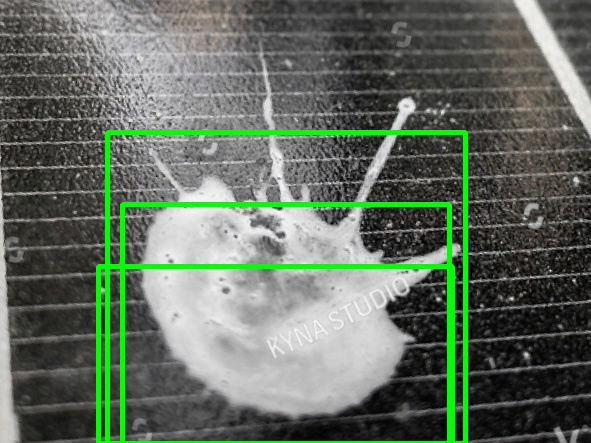

File: 30236fae-KakaoTalk_20251114_212824535_24.jpg
GT        = binary=1, count=1
PRED      = binary=1, count=3
------------------------------------------------------------


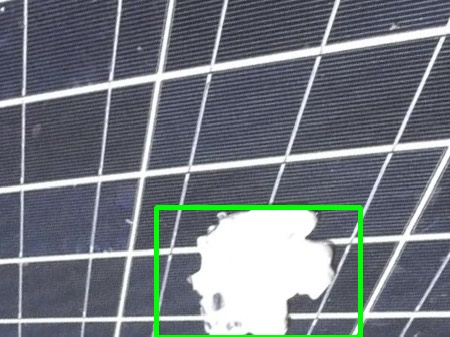

File: c2a14a7f-KakaoTalk_20251114_211845705_29.jpg
GT        = binary=1, count=1
PRED      = binary=1, count=1
------------------------------------------------------------


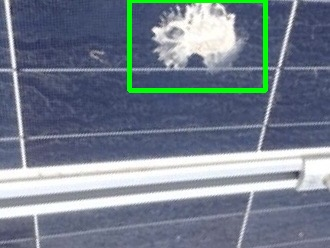

File: 485eb2fd-KakaoTalk_20251114_211845705_02.jpg
GT        = binary=1, count=1
PRED      = binary=1, count=1
------------------------------------------------------------


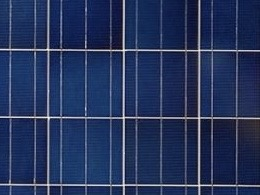

File: KakaoTalk_20251114_211843089_23.jpg
GT        = binary=0, count=0
PRED      = binary=0, count=0
------------------------------------------------------------


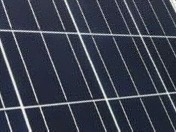

File: KakaoTalk_20251114_212856166_22.jpg
GT        = binary=0, count=0
PRED      = binary=0, count=0
------------------------------------------------------------


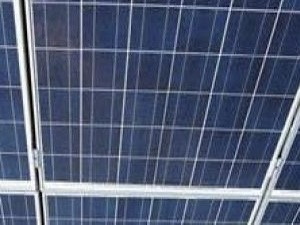

File: KakaoTalk_20251114_211843089_03.jpg
GT        = binary=0, count=0
PRED      = binary=0, count=0
------------------------------------------------------------


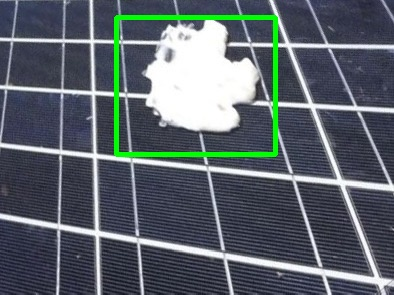

File: deddc023-KakaoTalk_20251114_211845705_08.jpg
GT        = binary=1, count=1
PRED      = binary=1, count=1
------------------------------------------------------------


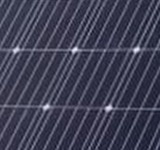

File: KakaoTalk_20251114_212856166_11.jpg
GT        = binary=0, count=0
PRED      = binary=0, count=0
------------------------------------------------------------


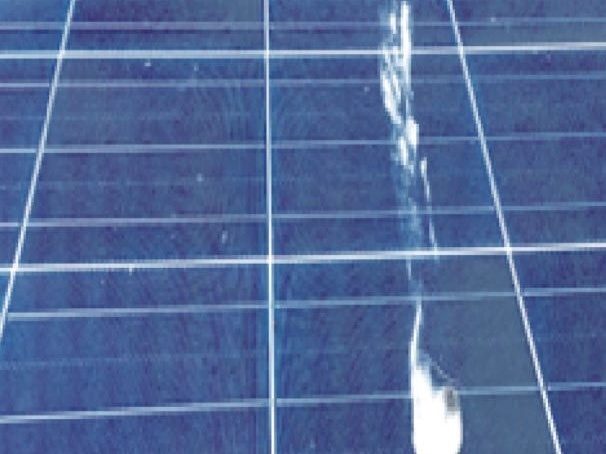

File: edcc1d7f-KakaoTalk_20251114_211845705_05.jpg
GT        = binary=1, count=1
PRED      = binary=0, count=0
------------------------------------------------------------


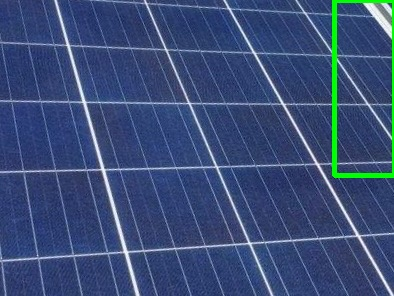

File: KakaoTalk_20251114_212856166_10.jpg
GT        = binary=0, count=0
PRED      = binary=1, count=1
------------------------------------------------------------


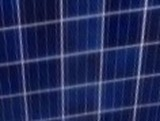

File: KakaoTalk_20251114_211843089_10.jpg
GT        = binary=0, count=0
PRED      = binary=0, count=0
------------------------------------------------------------


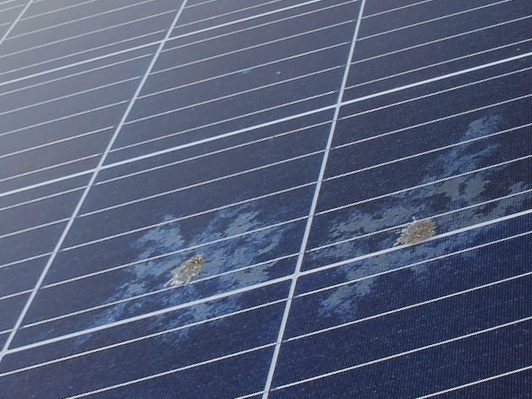

File: 8ec8f641-KakaoTalk_20251114_212824535_02.jpg
GT        = binary=1, count=2
PRED      = binary=0, count=0
------------------------------------------------------------


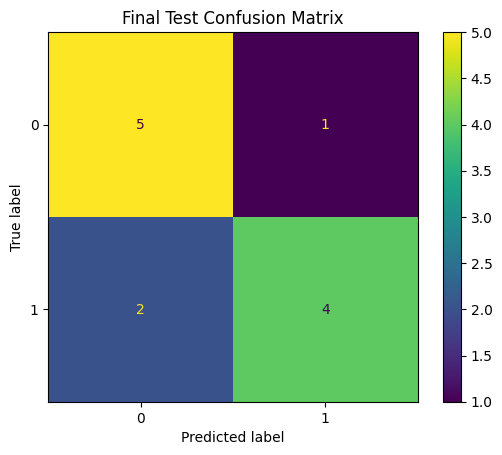

Accuracy: 0.75


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, Image
import cv2

def draw_boxes(image_path, boxes):
    img = cv2.imread(image_path)
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy.cpu().numpy().astype(int)[0]
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,255,0), 3)
    out_path = "/content/tmp_vis.jpg"
    cv2.imwrite(out_path, img)
    return out_path


model = YOLO(BEST_OVERALL)

y_true = []
y_pred = []

print("\n===== 최종 모델 Test Set 평가 =====")

for img, lbl, binary, cnt in test_pairs:
    results = model(str(img), verbose=False)
    boxes = results[0].boxes
    pred_count = len(boxes)
    pred_binary = 1 if pred_count > 0 else 0

    y_true.append(binary)
    y_pred.append(pred_binary)

    # 바운딩박스 시각화 이미지 생성
    vis = draw_boxes(str(img), boxes)

    # ★★ 원본 대신 박스가 그려진 이미지를 display ★★
    display(Image(filename=vis, height=300))

    print(f"File: {img.name}")
    print(f"GT        = binary={binary}, count={cnt}")
    print(f"PRED      = binary={pred_binary}, count={pred_count}")
    print("-"*60)

# Confusion Matrix 저장
y_true_np = np.array(y_true)
y_pred_np = np.array(y_pred)

disp = ConfusionMatrixDisplay.from_predictions(y_true_np, y_pred_np)
plt.title("Final Test Confusion Matrix")
plt.savefig("/content/test_confusion_matrix.png")
plt.show()

print("Accuracy:", (y_true_np == y_pred_np).mean())


🔵 8. NCNN export (라즈베리용)
근데 해결을 못해서

In [ ]:
# ============================================
# 0. 설정
# ============================================
SAVE_DIR = "/content/drive/MyDrive/캡스톤_청소해조/제어팀_브리핑/코드모음/김승연_최종본"
EXPORT_NAME = "export_ncnn_1117"     # 원하는 이름

LOCAL_ORIG = "/content/best_overall_ncnn_model"  # Ultralytics가 생성하는 이름
LOCAL_EXPORT = f"/content/{EXPORT_NAME}"         # 우리가 원하는 폴더 이름
LOCAL_ZIP = f"/content/{EXPORT_NAME}.zip"        # zip 파일

!yolo export \
    model={BEST_OVERALL} \
    format=ncnn \
    imgsz=640 \
    project=/content \
    name=dummy_temp_name
import shutil, os, time

# Drive sync 대기
time.sleep(1)

# 이전 데이터 삭제
shutil.rmtree(LOCAL_EXPORT, ignore_errors=True)

# Ultralytics export 폴더가 실제로 존재하는지 확인
if not os.path.exists(LOCAL_ORIG):
    raise FileNotFoundError("Ultralytics export 폴더가 생성되지 않았습니다. 로그 확인 필요.")

# 우리가 원하는 이름으로 rename
shutil.move(LOCAL_ORIG, LOCAL_EXPORT)

print("Renamed →", LOCAL_EXPORT)
!cd /content && zip -r {EXPORT_NAME}.zip {EXPORT_NAME}
print("ZIP 생성됨:", LOCAL_ZIP)

shutil.copy2(LOCAL_ZIP, SAVE_DIR)
print("Drive 저장 완료:", SAVE_DIR)




Ultralytics 8.3.229 🚀 Python-3.12.12 torch-2.8.0+cu126 CPU (Intel Xeon CPU @ 2.20GHz)
💡 ProTip: Export to OpenVINO format for best performance on Intel hardware. Learn more at https://docs.ultralytics.com/integrations/openvino/
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs

PyTorch: starting from '/content/best_overall.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 5, 8400) (5.2 MB)
requirements: Ultralytics requirement ['ncnn'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 1 package in 147ms
Prepared 1 package in 276ms
Installed 1 package in 3ms
 + ncnn==1.0.20250916

requirements: AutoUpdate success ✅ 0.9s
WARNING ⚠️ requirements: Restart runtime or rerun command for updates to take effect

requirements: Ultralytics requirement ['pnnx'] not found, attempting AutoUpdate...
Using Python 3.12.12 environment at: /usr
Resolved 26 packages in 141ms
Prepared 1 package in 414ms
Installed 1 packa

✅ 2) 최종 모델(BEST_OVERALL)로 Test Set 전체 ROC curve
+ Precision-Recall curve 출력 & 저장
+ ROC curve
+ Precision-Recall Curve

In [ ]:
# ============================================
# (B) Final Test ROC / PR Curve
# ============================================
from sklearn.metrics import roc_curve, auc, precision_recall_curve

model = YOLO(BEST_OVERALL)

y_true = []
y_score = []      # confidence 최대값
y_pred = []       # binary prediction

print("\n================ Final Test Predictions ================\n")

for img, lbl, binary, true_count in test_pairs:
    results = model(str(img), verbose=False)
    boxes = results[0].boxes

    # contam 여부 → binary
    pred_binary = 1 if len(boxes) > 0 else 0
    y_pred.append(pred_binary)

    # confidence score (없으면 0)
    if len(boxes) > 0:
        conf = float(boxes.conf.max())
    else:
        conf = 0.0
    y_score.append(conf)

    y_true.append(binary)

    # 디버깅 출력
    display(IPImage(filename=str(img), height=260))
    print(f"File: {img.name}")
    print(f"GT        : binary={binary}, count={true_count}")
    print(f"PRED      : binary={pred_binary}, count={len(boxes)}")
    print(f"CONF      : {conf:.3f}")
    print("-"*60)


y_true_np = np.array(y_true)
y_score_np = np.array(y_score)


# ROC Curve
fpr, tpr, _ = roc_curve(y_true_np, y_score_np)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Final Test ROC Curve")
plt.legend()
plt.grid(True)
plt.savefig("/content/test_ROC.png")
plt.show()

print("ROC curve saved → /content/test_ROC.png")




# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true_np, y_score_np)

plt.figure(figsize=(5, 5))
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Final Test Precision-Recall Curve")
plt.grid(True)
plt.savefig("/content/test_PR_curve.png")
plt.show()

print("PR curve saved → /content/test_PR_curve.png")



================ Final Test Predictions ================



NameError: name 'IPImage' is not defined

# 아래는 5fold 아니고 단순 7:2:1 모델
구구버전. 절대 돌리지 말아주세요.


In [ ]:
!nvidia-smi

Mon Nov 17 06:59:23 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
!unzip -q \
"/content/drive/MyDrive/캡스톤_청소해조/제어팀_브리핑/코드모음/김승연_최종본/data.zip" \
-d "/content/drive/MyDrive/캡스톤_청소해조/제어팀_브리핑/코드모음/김승연_최종본/custom_data"


In [ ]:
!wget -O /content/train_val_split.py https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py

# TO DO: Improve robustness of train_val_split.py script so it can handle nested data folders, etc
!python train_val_split.py --datapath="/content/custom_data" --train_pct=0.9

--2025-11-17 06:32:10--  https://raw.githubusercontent.com/EdjeElectronics/Train-and-Deploy-YOLO-Models/refs/heads/main/utils/train_val_split.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3203 (3.1K) [text/plain]
Saving to: ‘/content/train_val_split.py’

/content/train_val_ 100%[===================>]   3.13K  --.-KB/s    in 0s      

2025-11-17 06:32:10 (48.8 MB/s) - ‘/content/train_val_split.py’ saved [3203/3203]

Created folder at /content/data/train/images.
Created folder at /content/data/train/labels.
Created folder at /content/data/validation/images.
Created folder at /content/data/validation/labels.
Number of image files: 104
Number of annotation files: 104
Images moving to train: 93
Images moving to validation: 11


In [ ]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 61.1 MB/s eta 0:00:00


In [ ]:
# ============================================
# 1. 경로 설정 & data.zip 풀기
#    - 반드시 네 드라이브 경로와 같아야 함
# ============================================
BASE_DIR = "/content/drive/MyDrive/캡스톤_청소해조/제어팀_브리핑/코드모음/김승연_최종본"
ZIP_PATH = f"{BASE_DIR}/data.zip"

RAW_DIR = "/content/custom_data_raw"   # zip 풀어서 쓸 임시 폴더
DATA_ROOT = "/content/data"            # YOLO 학습용 최종 폴더

import os, shutil, zipfile, random, pathlib

# 깨끗하게 비우기
shutil.rmtree(RAW_DIR, ignore_errors=True)
shutil.rmtree(DATA_ROOT, ignore_errors=True)

os.makedirs(RAW_DIR, exist_ok=True)

# data.zip 풀기 (결과: RAW_DIR/images, RAW_DIR/labels, RAW_DIR/classes.txt)
with zipfile.ZipFile(ZIP_PATH, 'r') as z:
    z.extractall(RAW_DIR)

print("RAW_DIR 내용:", os.listdir(RAW_DIR))

RAW_DIR 내용: ['classes.txt', 'labels', 'images', 'notes.json']


In [ ]:
# ============================================
# 2. 이미지/라벨 파일 읽어서 clean/contam 나누기
#    - YOLO 라벨이 비어 있으면 clean(0)
#    - 내용이 있으면 contaminated(1)
# ============================================
img_dir = pathlib.Path(RAW_DIR) / "images"
lbl_dir = pathlib.Path(RAW_DIR) / "labels"

img_exts = [".jpg", ".jpeg", ".png"]

pairs = []  # (img_path, label_path, binary_label, true_count)

for lbl_path in sorted(lbl_dir.glob("*.txt")):
    stem = lbl_path.stem
    img_path = None
    for ext in img_exts:
        candidate = img_dir / f"{stem}{ext}"
        if candidate.exists():
            img_path = candidate
            break
    if img_path is None:
        print(f"[WARN] {stem}에 대응하는 이미지가 없음")
        continue

    txt = lbl_path.read_text(encoding="utf-8").strip()
    if txt == "":
        binary = 0
        true_count = 0
    else:
        lines = [ln for ln in txt.splitlines() if ln.strip()]
        binary = 1
        true_count = len(lines)

    pairs.append((img_path, lbl_path, binary, true_count))

print(f"총 샘플 수: {len(pairs)}")

contam = [p for p in pairs if p[2] == 1]
clean  = [p for p in pairs if p[2] == 0]

print(f"contaminated 이미지: {len(contam)}")
print(f"clean 이미지:        {len(clean)}")

총 샘플 수: 104
contaminated 이미지: 52
clean 이미지:        52


In [ ]:

# ============================================
# 3. contam / clean 각각 7:2:1으로 split 후 합치기
#    - 각 split마다 contam:clean = 1:1 유지
# ============================================
def split_7_2_1(lst, seed=42):
    random.Random(seed).shuffle(lst)
    n = len(lst)
    n_train = int(n * 0.7)
    n_val   = int(n * 0.2)
    n_test  = n - n_train - n_val
    train = lst[:n_train]
    val   = lst[n_train:n_train+n_val]
    test  = lst[n_train+n_val:]
    return train, val, test

contam_train, contam_val, contam_test = split_7_2_1(contam, seed=0)
clean_train,  clean_val,  clean_test  = split_7_2_1(clean,  seed=1)

train_pairs = contam_train + clean_train
val_pairs   = contam_val   + clean_val
test_pairs  = contam_test  + clean_test

# 섞어서 순서 랜덤화
random.shuffle(train_pairs)
random.shuffle(val_pairs)
random.shuffle(test_pairs)

def count_binary(pairs):
    c1 = sum(1 for p in pairs if p[2] == 1)
    c0 = sum(1 for p in pairs if p[2] == 0)
    return c0, c1

print("\n[Split 결과] (clean, contaminated)")
print("train:", count_binary(train_pairs))
print("val  :", count_binary(val_pairs))
print("test :", count_binary(test_pairs))


[Split 결과] (clean, contaminated)
train: (36, 36)
val  : (10, 10)
test : (6, 6)


In [ ]:
# ============================================
# 4. /content/data/train|validation|test 구조로 복사
# ============================================
for split in ["train", "validation", "test"]:
    os.makedirs(os.path.join(DATA_ROOT, split, "images"), exist_ok=True)
    os.makedirs(os.path.join(DATA_ROOT, split, "labels"), exist_ok=True)

def copy_pairs(pairs, split_name):
    for img_path, lbl_path, binary, true_count in pairs:
        stem = img_path.stem
        # 이미지 복사
        dst_img = os.path.join(DATA_ROOT, split_name, "images", img_path.name)
        shutil.copy2(str(img_path), dst_img)
        # 라벨 복사 (비어있어도 그대로)
        dst_lbl = os.path.join(DATA_ROOT, split_name, "labels", stem + ".txt")
        shutil.copy2(str(lbl_path), dst_lbl)

copy_pairs(train_pairs, "train")
copy_pairs(val_pairs,   "validation")
copy_pairs(test_pairs,  "test")

# classes.txt도 같이 복사 (선택사항)
shutil.copy2(os.path.join(RAW_DIR, "classes.txt"),
             os.path.join(DATA_ROOT, "classes.txt"))

print("\n/data 구조:")
for root, dirs, files in os.walk(DATA_ROOT):
    print(root, " → dirs:", dirs, " files:", len(files))


/data 구조:
/content/data  → dirs: ['train', 'validation', 'test']  files: 1
/content/data/train  → dirs: ['labels', 'images']  files: 0
/content/data/train/labels  → dirs: []  files: 72
/content/data/train/images  → dirs: []  files: 72
/content/data/validation  → dirs: ['labels', 'images']  files: 0
/content/data/validation/labels  → dirs: []  files: 20
/content/data/validation/images  → dirs: []  files: 20
/content/data/test  → dirs: ['labels', 'images']  files: 0
/content/data/test/labels  → dirs: []  files: 12
/content/data/test/images  → dirs: []  files: 12


In [ ]:
# ============================================
# 5. data.yaml 생성 (nc=1, names=['contaminated'])
# ============================================
import yaml

data_yaml_path = "/content/data.yaml"
data_cfg = {
    "path": DATA_ROOT,
    "train": "train/images",
    "val":   "validation/images",
    "test":  "test/images",
    "nc": 1,
    "names": ["contaminated"],
}

with open(data_yaml_path, "w") as f:
    yaml.dump(data_cfg, f, sort_keys=False)

print("\n[data.yaml]")
print(open(data_yaml_path).read())


[data.yaml]
path: /content/data
train: train/images
val: validation/images
test: test/images
nc: 1
names:
- contaminated



In [ ]:
# ============================================
# 6. Ultralytics 설치 & 모델 학습
# ============================================
!pip install ultralytics -q

from ultralytics import YOLO

# yolo11n.pt 사용 (Pi에서 더 가볍게 돌리기 위해)
!yolo detect train \
  data=/content/data.yaml \
  model=yolo11n.pt \
  epochs=60 \
  imgsz=640 \
  project=/content/runs_detect \
  name=capstone_clean_contam

BEST_WEIGHTS = "/content/runs_detect/capstone_clean_contam/weights/best.pt"
print("\nBest weights:", BEST_WEIGHTS)

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
Ultralytics 8.3.228 🚀 Python-3.12.12 torch-2.8.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=60, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj


========== VALIDATION SET 평가 ==========


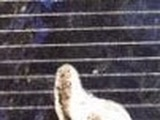

File      : 3098f9c5-KakaoTalk_20251114_212824535_15.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


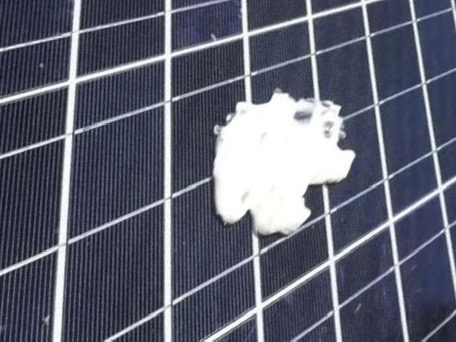

File      : 499cbaa6-KakaoTalk_20251114_211845705_28.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


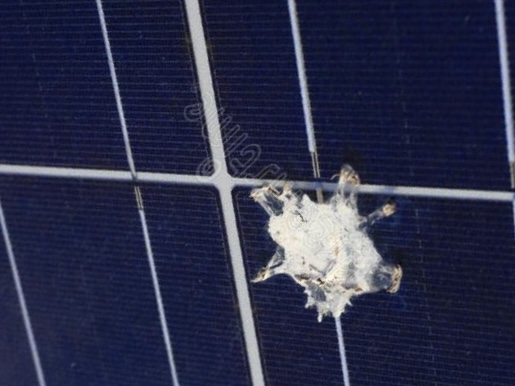

File      : 57b99abb-KakaoTalk_20251114_211845705_13.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


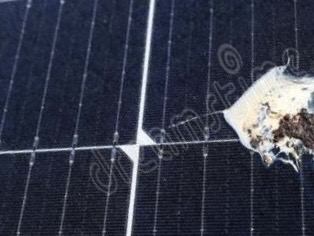

File      : 5d1b73d3-KakaoTalk_20251114_211845705_15.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


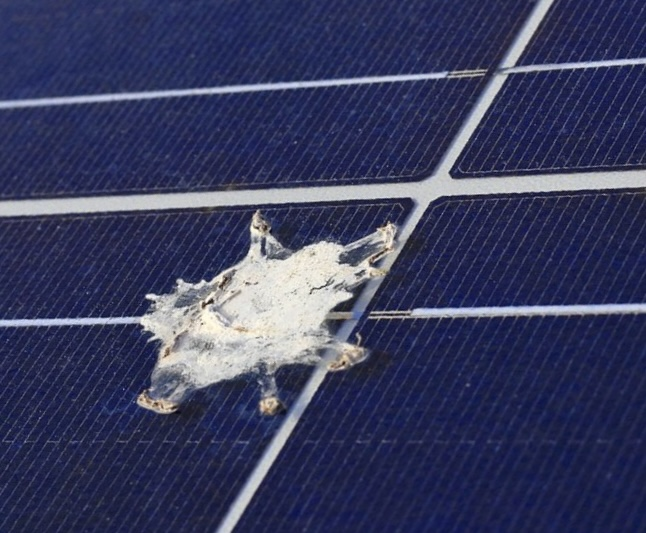

File      : 74f5ec38-KakaoTalk_20251114_212824535_21.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


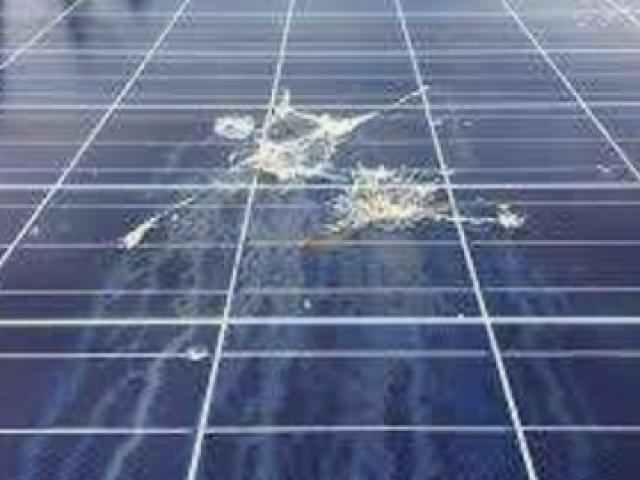

File      : 79c3a0c9-KakaoTalk_20251114_211845705_01.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


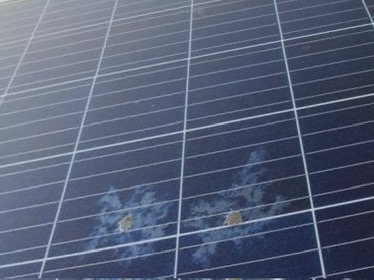

File      : 9cd7fa30-KakaoTalk_20251114_211846182.jpg
GT        : binary=1, count=2
PRED      : binary=1, count=2
------------------------------------------------------------


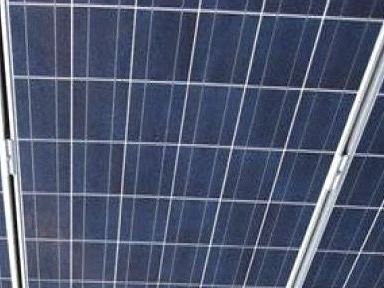

File      : KakaoTalk_20251114_211843089_02.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


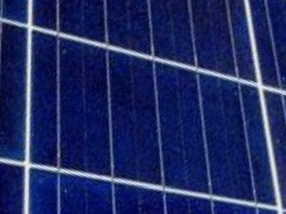

File      : KakaoTalk_20251114_211843089_07.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


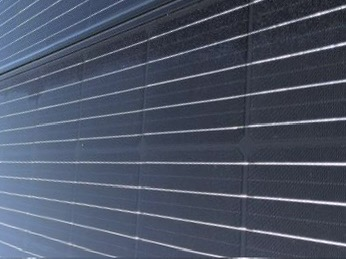

File      : KakaoTalk_20251114_211843089_14.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


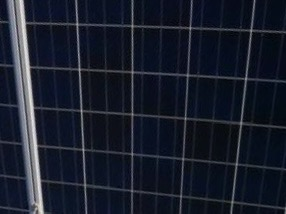

File      : KakaoTalk_20251114_211843089_25.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


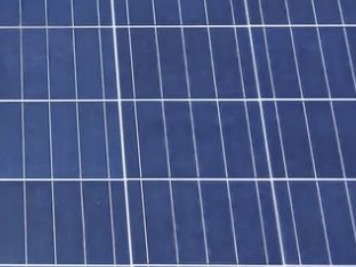

File      : KakaoTalk_20251114_212856166_01.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


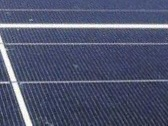

File      : KakaoTalk_20251114_212856166_03.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


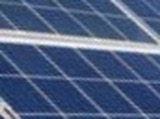

File      : KakaoTalk_20251114_212856166_04.jpg
GT        : binary=0, count=0
PRED      : binary=1, count=1
------------------------------------------------------------


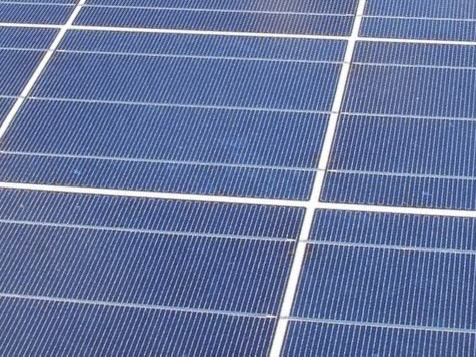

File      : KakaoTalk_20251114_212856166_14.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


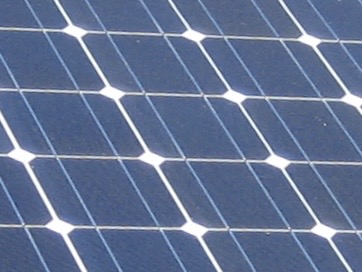

File      : KakaoTalk_20251114_212856166_15.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


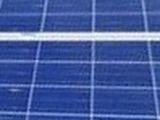

File      : KakaoTalk_20251114_212856166_18.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


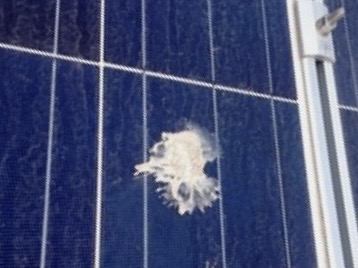

File      : a76a1c95-KakaoTalk_20251114_211845705_04.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


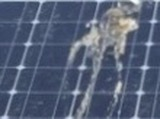

File      : ba7e22c6-KakaoTalk_20251114_212824535_07.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


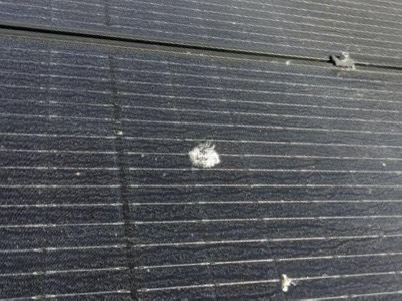

File      : f263a494-KakaoTalk_20251114_211845705_18.jpg
GT        : binary=1, count=2
PRED      : binary=1, count=2
------------------------------------------------------------

[Confusion Matrix] (binary frame-level)
           True 1   True 0
Pred 1 :     10        1
Pred 0 :      0        9

[Metrics]
Total frames : 20
Accuracy     : 0.950
Precision(1) : 0.909
Recall(1)    : 1.000
F1(1)        : 0.952

========== TEST SET 평가 ==========


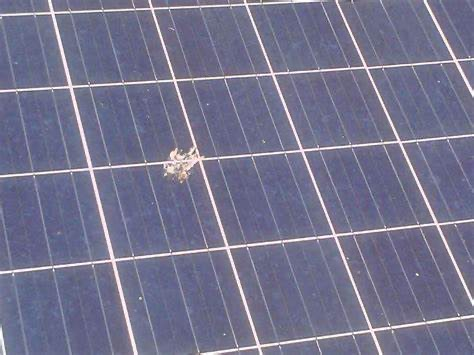

File      : 1828f2e2-KakaoTalk_20251114_212824535_19.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


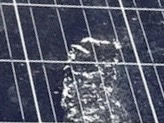

File      : 4f5f89b9-KakaoTalk_20251114_212824535_08.jpg
GT        : binary=1, count=1
PRED      : binary=0, count=0
------------------------------------------------------------


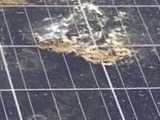

File      : 76fcb4db-KakaoTalk_20251114_212824535_11.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


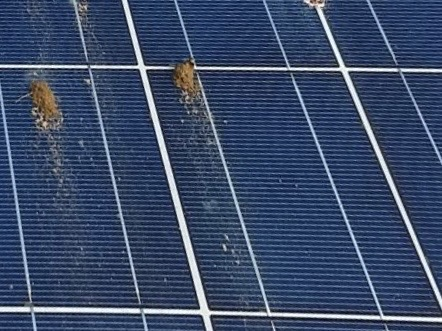

File      : 7d438a6d-KakaoTalk_20251114_211845705_27.jpg
GT        : binary=1, count=2
PRED      : binary=1, count=1
------------------------------------------------------------


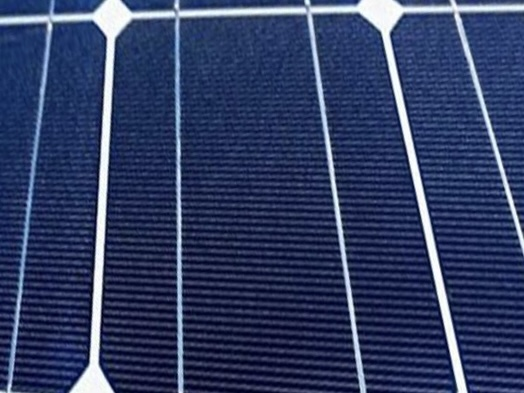

File      : KakaoTalk_20251114_211843089_05.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


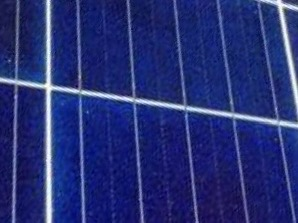

File      : KakaoTalk_20251114_211843089_08.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


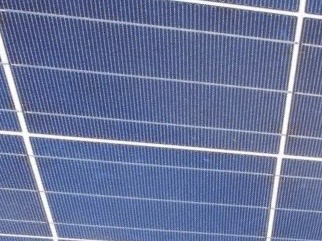

File      : KakaoTalk_20251114_211843089_09.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


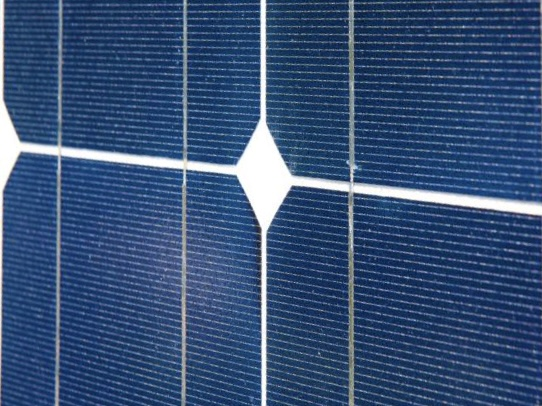

File      : KakaoTalk_20251114_211843089_17.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


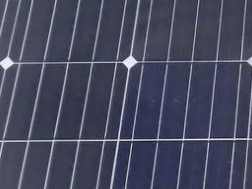

File      : KakaoTalk_20251114_212856166_09.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


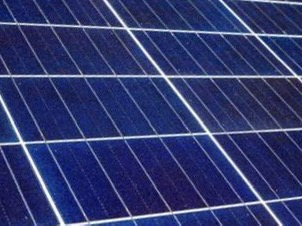

File      : KakaoTalk_20251114_212856166_21.jpg
GT        : binary=0, count=0
PRED      : binary=0, count=0
------------------------------------------------------------


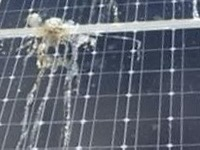

File      : a973abdc-KakaoTalk_20251114_212824535_01.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------


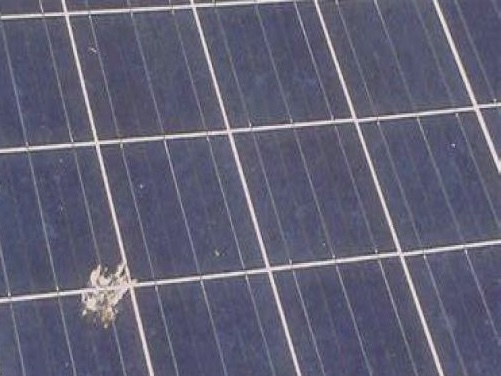

File      : f9e85049-KakaoTalk_20251114_211845705_26.jpg
GT        : binary=1, count=1
PRED      : binary=1, count=1
------------------------------------------------------------

[Confusion Matrix] (binary frame-level)
           True 1   True 0
Pred 1 :      5        0
Pred 0 :      1        6

[Metrics]
Total frames : 12
Accuracy     : 0.917
Precision(1) : 1.000
Recall(1)    : 0.833
F1(1)        : 0.909


In [ ]:
# ============================================
# 7. validation / test 셋 평가
#    - 각 이미지마다:
#       * pred_count, pred_binary
#       * true_count, true_binary
#    - 전체 confusion matrix & 지표 출력
# ============================================
from IPython.display import display, Image as IPImage
import glob

model = YOLO(BEST_WEIGHTS)

def eval_split(split_name):
    img_dir = os.path.join(DATA_ROOT, split_name, "images")
    lbl_dir = os.path.join(DATA_ROOT, split_name, "labels")

    img_paths = sorted(
        p for p in glob.glob(os.path.join(img_dir, "*"))
        if os.path.splitext(p)[1].lower() in [".jpg", ".jpeg", ".png"]
    )

    y_true = []
    y_pred = []

    print(f"\n========== {split_name.upper()} SET 평가 ==========")

    for img_path in img_paths:
        stem = os.path.splitext(os.path.basename(img_path))[0]
        lbl_path = os.path.join(lbl_dir, stem + ".txt")

        # --- GT 라벨 ---
        if os.path.exists(lbl_path):
            txt = open(lbl_path, "r").read().strip()
            if txt == "":
                true_binary = 0
                true_count = 0
            else:
                lines = [ln for ln in txt.splitlines() if ln.strip()]
                true_binary = 1
                true_count  = len(lines)
        else:
            true_binary = 0
            true_count  = 0

        # --- 모델 예측 ---
        results = model(img_path, verbose=False)
        boxes = results[0].boxes
        pred_count = len(boxes)
        pred_binary = 1 if pred_count > 0 else 0

        y_true.append(true_binary)
        y_pred.append(pred_binary)

        # 디버깅용 출력 (이미지 + 정보)
        display(IPImage(filename=img_path, height=300))
        print(f"File      : {os.path.basename(img_path)}")
        print(f"GT        : binary={true_binary}, count={true_count}")
        print(f"PRED      : binary={pred_binary}, count={pred_count}")
        print("-"*60)

    # --- confusion matrix & 지표 ---
    import numpy as np

    y_true_np = np.array(y_true)
    y_pred_np = np.array(y_pred)

    TP = int(((y_true_np == 1) & (y_pred_np == 1)).sum())
    TN = int(((y_true_np == 0) & (y_pred_np == 0)).sum())
    FP = int(((y_true_np == 0) & (y_pred_np == 1)).sum())
    FN = int(((y_true_np == 1) & (y_pred_np == 0)).sum())

    total = len(y_true_np)
    acc = (TP + TN) / total if total > 0 else 0.0
    prec = TP / (TP + FP) if (TP + FP) > 0 else 0.0
    rec  = TP / (TP + FN) if (TP + FN) > 0 else 0.0
    if (prec + rec) > 0:
        f1 = 2 * prec * rec / (prec + rec)
    else:
        f1 = 0.0

    print(f"\n[Confusion Matrix] (binary frame-level)")
    print(f"           True 1   True 0")
    print(f"Pred 1 :    {TP:3d}      {FP:3d}")
    print(f"Pred 0 :    {FN:3d}      {TN:3d}")

    print(f"\n[Metrics]")
    print(f"Total frames : {total}")
    print(f"Accuracy     : {acc:.3f}")
    print(f"Precision(1) : {prec:.3f}")
    print(f"Recall(1)    : {rec:.3f}")
    print(f"F1(1)        : {f1:.3f}")

# validation / test 둘 다 평가
eval_split("validation")
eval_split("test")